<a href="https://colab.research.google.com/github/spentaur/DS-Unit-1-Sprint-1-Dealing-With-Data/blob/master/module1-afirstlookatdata/LS_DS_111_A_First_Look_at_Data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lambda School Data Science - A First Look at Data



## Lecture - let's explore Python DS libraries and examples!

The Python Data Science ecosystem is huge. You've seen some of the big pieces - pandas, scikit-learn, matplotlib. What parts do you want to see more of?

In [1]:
# TODO - we'll be doing this live, taking requests
# and reproducing what it is to look up and learn things
2 + 2

4

In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [0]:
drinks = pd.read_csv('https://raw.githubusercontent.com/fivethirtyeight/data/master/alcohol-consumption/drinks.csv')

In [4]:
drinks.sort_values(by='beer_servings', ascending=False).head(10)

,country,beer_servings,spirit_servings,wine_servings,total_litres_of_pure_alcohol
117,Namibia,376,3,1,6.8
45,Czech Republic,361,170,134,11.8
62,Gabon,347,98,59,8.9
65,Germany,346,117,175,11.3
98,Lithuania,343,244,56,12.9
135,Poland,343,215,56,10.9
188,Venezuela,333,100,3,7.7
81,Ireland,313,118,165,11.4
129,Palau,306,63,23,6.9
140,Romania,297,122,167,10.4


In [0]:
drinks['drinks_alcohol'] = np.where(drinks['total_litres_of_pure_alcohol'] > 0, 'Yes', 'No')

In [6]:
drinks.head()

,country,beer_servings,spirit_servings,wine_servings,total_litres_of_pure_alcohol,drinks_alcohol
0,Afghanistan,0,0,0,0.0,No
1,Albania,89,132,54,4.9,Yes
2,Algeria,25,0,14,0.7,Yes
3,Andorra,245,138,312,12.4,Yes
4,Angola,217,57,45,5.9,Yes


count    193.000000
mean       4.717098
std        3.773298
min        0.000000
25%        1.300000
50%        4.200000
75%        7.200000
max       14.400000
Name: total_litres_of_pure_alcohol, dtype: float64

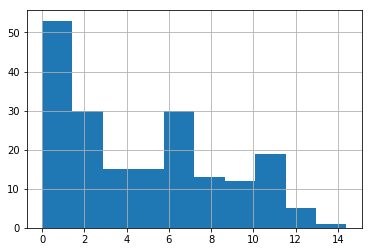

In [7]:
drinks.total_litres_of_pure_alcohol.hist()
drinks['total_litres_of_pure_alcohol'].describe()

In [0]:
drinks['drinks_alcohol'] = np.where(drinks['total_litres_of_pure_alcohol'] > 7.2, 'high',
                           np.where(drinks['total_litres_of_pure_alcohol'] > 4.2, 'medium',
                           np.where(drinks['total_litres_of_pure_alcohol'] == 0, 'none', 'low')))

In [9]:
drinks['drinks_alcohol'].value_counts()

low       84
medium    49
high      47
none      13
Name: drinks_alcohol, dtype: int64

In [10]:
countries = pd.read_csv('https://raw.githubusercontent.com/lukes/ISO-3166-Countries-with-Regional-Codes/master/all/all.csv')
print(countries.shape)
countries.head()

(249, 11)


,name,alpha-2,alpha-3,country-code,iso_3166-2,region,sub-region,intermediate-region,region-code,sub-region-code,intermediate-region-code
0,Afghanistan,AF,AFG,4,ISO 3166-2:AF,Asia,Southern Asia,NaN,142.0,34.0,NaN
1,Åland Islands,AX,ALA,248,ISO 3166-2:AX,Europe,Northern Europe,NaN,150.0,154.0,NaN
2,Albania,AL,ALB,8,ISO 3166-2:AL,Europe,Southern Europe,NaN,150.0,39.0,NaN
3,Algeria,DZ,DZA,12,ISO 3166-2:DZ,Africa,Northern Africa,NaN,2.0,15.0,NaN
4,American Samoa,AS,ASM,16,ISO 3166-2:AS,Oceania,Polynesia,NaN,9.0,61.0,NaN


In [11]:
countries[['name', 'region', 'sub-region']]

,name,region,sub-region
0,Afghanistan,Asia,Southern Asia
1,Åland Islands,Europe,Northern Europe
2,Albania,Europe,Southern Europe
3,Algeria,Africa,Northern Africa
4,American Samoa,Oceania,Polynesia
5,Andorra,Europe,Southern Europe
6,Angola,Africa,Sub-Saharan Africa
7,Anguilla,Americas,Latin America and the Caribbean
8,Antarctica,NaN,NaN
9,Antigua and Barbuda,Americas,Latin America and the Caribbean


In [0]:
drinks.at[184, 'country'] = "United States of America"

In [0]:
df = pd.merge(drinks, countries[['name', 'region', 'sub-region']], how='left', left_on='country', right_on='name')

In [14]:
df.isnull().sum()

country                          0
beer_servings                    0
spirit_servings                  0
wine_servings                    0
total_litres_of_pure_alcohol     0
drinks_alcohol                   0
name                            25
region                          25
sub-region                      25
dtype: int64

In [15]:
df[df['name'].isna()].head(30)

,country,beer_servings,spirit_servings,wine_servings,total_litres_of_pure_alcohol,drinks_alcohol,name,region,sub-region
5,Antigua & Barbuda,102,128,45,4.9,medium,NaN,NaN,NaN
20,Bolivia,167,41,8,3.8,low,NaN,NaN,NaN
21,Bosnia-Herzegovina,76,173,8,4.6,medium,NaN,NaN,NaN
24,Brunei,31,2,1,0.6,low,NaN,NaN,NaN
28,Cote d'Ivoire,37,1,7,4.0,low,NaN,NaN,NaN
45,Czech Republic,361,170,134,11.8,high,NaN,NaN,NaN
46,North Korea,0,0,0,0.0,none,NaN,NaN,NaN
47,DR Congo,32,3,1,2.3,low,NaN,NaN,NaN
79,Iran,0,0,0,0.0,none,NaN,NaN,NaN
92,Laos,62,0,123,6.2,medium,NaN,NaN,NaN


In [16]:
df.head()

,country,beer_servings,spirit_servings,wine_servings,total_litres_of_pure_alcohol,drinks_alcohol,name,region,sub-region
0,Afghanistan,0,0,0,0.0,none,Afghanistan,Asia,Southern Asia
1,Albania,89,132,54,4.9,medium,Albania,Europe,Southern Europe
2,Algeria,25,0,14,0.7,low,Algeria,Africa,Northern Africa
3,Andorra,245,138,312,12.4,high,Andorra,Europe,Southern Europe
4,Angola,217,57,45,5.9,medium,Angola,Africa,Sub-Saharan Africa


In [17]:
df['sub-region'].value_counts()

Sub-Saharan Africa                 42
Latin America and the Caribbean    26
Western Asia                       16
Southern Europe                    12
Northern Europe                     9
Southern Asia                       8
Western Europe                      8
Eastern Europe                      8
South-eastern Asia                  8
Northern Africa                     6
Polynesia                           5
Central Asia                        5
Micronesia                          4
Melanesia                           4
Eastern Asia                        3
Australia and New Zealand           2
Northern America                    2
Name: sub-region, dtype: int64

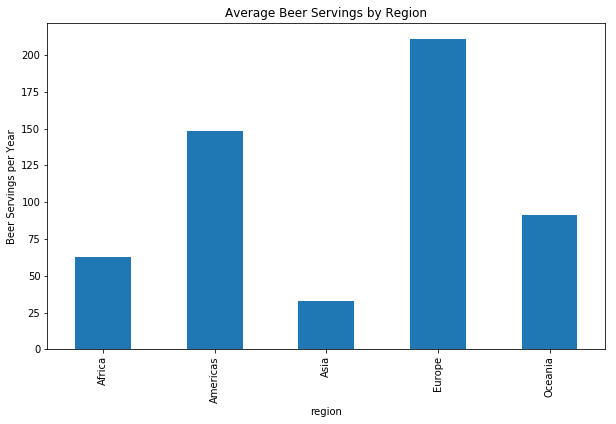

In [18]:
df.groupby('region')['beer_servings'].mean().plot(kind="bar", figsize=(10,6))
plt.title('Average Beer Servings by Region')
plt.ylabel('Beer Servings per Year')
plt.show()

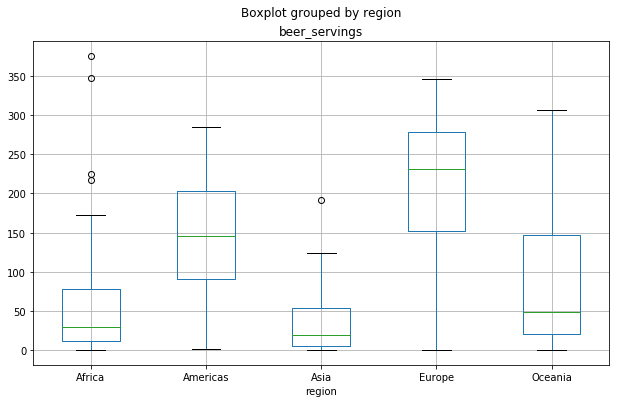

In [19]:
df.boxplot(column="beer_servings", by="region", figsize=(10,6));

In [0]:
df = df.dropna()

In [21]:
df.shape

(168, 9)

In [22]:
from bokeh.io import output_file, show, output_notebook
from bokeh.models import ColumnDataSource, HoverTool, CategoricalColorMapper
from bokeh.palettes import d3
from bokeh.plotting import figure
from bokeh.transform import transform
output_notebook()
x = df.beer_servings.values
y = df.wine_servings.values
country = df.country
region = df.region
source = ColumnDataSource(data=dict(x=x, y=y, country=country, region=region))
hover = HoverTool(tooltips=[
    ("index", "$index"),
    ("(x,y)", "(@x, @y)"),
    ('country', '@country'),
])
palette = d3['Category10'][len(df['region'].unique())]
mapper = CategoricalColorMapper(factors = df['region'].unique(), palette = palette)
# create figure and plot
p = figure(plot_width=600, plot_height=600, 
           tools=[hover, "wheel_zoom", "box_zoom", "reset"], 
           title="Beer and Wine Servings per Year by Country")
# create plot
p.scatter(x='x', y='y', size=10, alpha=0.8,
          color={'field': 'region', 'transform': mapper},
          legend='region', 
          source=source)
# add axis labels
p.xaxis.axis_label = "Beer Servings"
p.yaxis.axis_label = "Wine Servings"
output_file('interactive_bokeh_plot.html')
show(p)

Loading BokehJS ...

## Assignment - now it's your turn

Pick at least one Python DS library, and using documentation/examples reproduce in this notebook something cool. It's OK if you don't fully understand it or get it 100% working, but do put in effort and look things up.

In [0]:
# TODO - your code here
# Use what we did live in lecture as an example

### Assignment questions

After you've worked on some code, answer the following questions in this text block:

1.  Describe in a paragraph of text what you did and why, as if you were writing an email to somebody interested but nontechnical.

2.  What was the most challenging part of what you did?

3.  What was the most interesting thing you learned?

4.  What area would you like to explore with more time?




## Stretch goals and resources

Following are *optional* things for you to take a look at. Focus on the above assignment first, and make sure to commit and push your changes to GitHub (and since this is the first assignment of the sprint, open a PR as well).

- [pandas documentation](https://pandas.pydata.org/pandas-docs/stable/)
- [scikit-learn documentation](http://scikit-learn.org/stable/documentation.html)
- [matplotlib documentation](https://matplotlib.org/contents.html)
- [Awesome Data Science](https://github.com/bulutyazilim/awesome-datascience) - a list of many types of DS resources

Stretch goals:

- Find and read blogs, walkthroughs, and other examples of people working through cool things with data science - and share with your classmates!
- Write a blog post (Medium is a popular place to publish) introducing yourself as somebody learning data science, and talking about what you've learned already and what you're excited to learn more about.